<a href="https://colab.research.google.com/github/Sirfowahid/FFN/blob/master/FNN_Missing_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

labels = data[:,0]
data = data[:,1:]

In [ ]:
dataNorm = data / np.max(data)

dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()




where7 = labels==7


dataNo7   = dataT[~where7,:]
labelsNo7 = labelsT[~where7]
data7     = dataT[where7,:] 

train_data = TensorDataset(dataNo7,labelsNo7)
test_data  = TensorDataset(data7)


batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
np.unique(labelsNo7)

array([0, 1, 2, 3, 4, 5, 6, 8, 9])

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10) # NOTE: still 10 outputs, but output #7 is never trained

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NOTE: log-softmax output for later inspection
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
# a function that trains the model

# NOTE: anything test-related can be deleted!

def funtion2trainTheModel():

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)
  # end epochs

  # function output
  return trainAcc,losses,net


In [ ]:
trainAcc,losses,net = funtion2trainTheModel()


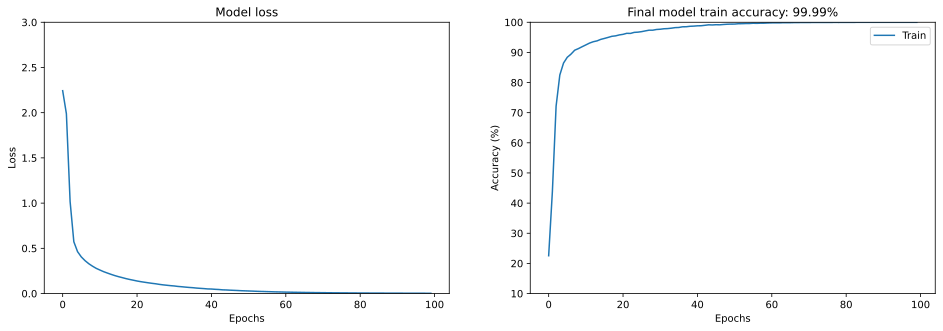

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model train accuracy: {trainAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# run the model through for the test data
X = next(iter(test_loader))[0] # note: only need one output, hence the [0]
predictions = net(X).detach()

# save the model guesses
guesses = torch.argmax(predictions,axis=1).detach()

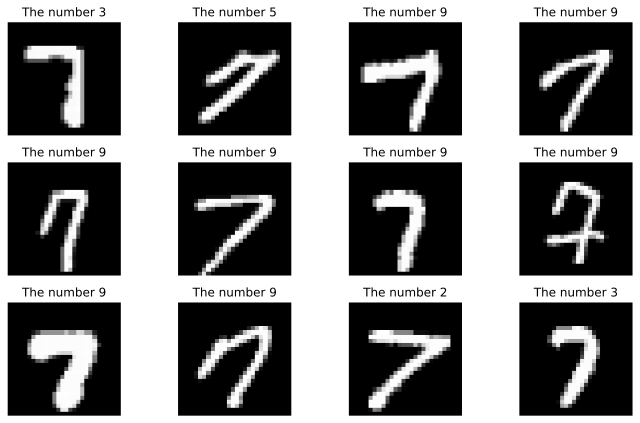

In [ ]:
# show some 7's and their labels

fig,axs = plt.subplots(3,4,figsize=(10,6))

someRandom7s = np.random.choice(len(X),12)

for i,ax in enumerate(axs.flatten()):

  thisimg = X[ someRandom7s[i] ].view(28,28)
  ax.imshow(thisimg,cmap='gray')
  ax.set_title(f'The number {guesses[ someRandom7s[i] ]}')
  ax.axis('off')

plt.tight_layout()
plt.show()